In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

import numpy as np

# Chargement du dataset Spambase
# Alternative si fetch_openml ne fonctionne pas : utiliser le code de génération ci-dessous
try:
    spam_data = fetch_openml("spambase", version=1, parser="auto")
    X = pd.DataFrame(spam_data.data, columns=spam_data.feature_names)
    y = spam_data.target.astype(int)
except:
    # Génération d'un dataset synthétique réaliste
    from sklearn.datasets import make_classification

    np.random.seed(42)
    X_base, y = make_classification(
        n_samples=4601,
        n_features=57,
        n_informative=45,
        n_redundant=12,
        n_classes=2,
        weights=[0.6, 0.4],  # 40% de spam
        flip_y=0.05,
        random_state=42,
    )

    # Création de noms de features réalistes
    feature_names = (
        [
            f"word_freq_{w}"
            for w in [
                "make",
                "address",
                "all",
                "free",
                "business",
                "email",
                "you",
                "credit",
                "money",
                "order",
            ]
        ]
        + [f"word_freq_generic_{i}" for i in range(1, 38)]
        + [
            f"char_freq_{c}"
            for c in [
                "semicolon",
                "parenthesis",
                "bracket",
                "exclamation",
                "dollar",
                "hashtag",
            ]
        ]
        + ["capital_run_avg", "capital_run_longest", "capital_run_total"]
    )

    X = pd.DataFrame(X_base, columns=feature_names)
    # Assurer des valeurs positives (fréquences)
    X = X.abs()

print(f"Dataset : {X.shape[0]} emails, {X.shape[1]} caractéristiques")
print(f"Proportion de spam : {y.mean():.1%}")

Dataset : 4601 emails, 57 caractéristiques
Proportion de spam : 39.4%


## Étapes à réaliser

### 1. Exploration et préparation

- Vérifiez les valeurs manquantes
- Divisez en train/test (80/20) avec `stratify=y`
- Standardisez les données avec `StandardScaler`

In [2]:
def analyse_missing_date(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    df_missing = pd.DataFrame(
        {
            "Colonnes": missing.index,
            "Valeurs manquantes": missing.values,
            "Pourcentages": missing_pct.values,
        }
    )
    df_missing = df_missing[df_missing["Valeurs manquantes"] > 0].sort_values(
        "Pourcentages", ascending=False
    )
    return df_missing


missing_data = analyse_missing_date(X)
if len(missing_data) > 0:
    missing_data.head(len(missing_data))
else:
    print("Pas de valeur manqante")

Pas de valeur manqante


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y, test_size=0.2
)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

### 2. Modèles de base (Baseline)

Entraînez 4 modèles simples pour avoir une référence : LogisticRegression, GaussianNB, SVC, DecisionTreeClassifier

- Quel modèle baseline est le meilleur ?
- Quelle métrique est la plus importante pour un filtre anti-spam ? (Accuracy, Precision, Recall ?)
  - **Precision** : Parmi les emails classés comme spam, combien sont vraiment des spams ?
  - **Recall** : Parmi tous les spams, combien sont détectés ?

### 3. Voting Classifier

**Questions** :

- Comparez hard et soft voting
- Lequel performe le mieux ?
- Le voting surpasse-t-il les modèles individuels ?

### 4. Tableau comparatif et analyse

Créez un tableau résumant TOUS vos résultats

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

estimators = [
    ("lr", LogisticRegression()),
    ("gnb", GaussianNB()),
    ("dt", DecisionTreeClassifier(random_state=42)),
    ("svc", SVC(random_state=42, probability=True)),
]

voting_pipeline_hard = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", VotingClassifier(estimators=estimators, voting="hard")),
    ]
)

models = {
    "LogisticRegression": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clf", LogisticRegression()),
        ]
    ),
    "GaussianNB": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clf", GaussianNB()),
        ]
    ),
    "SVC": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clf", SVC(random_state=42)),
        ]
    ),
    "DecisionTreeClassifier": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clf", DecisionTreeClassifier(random_state=42)),
        ]
    ),
    "VotingClassifier(voting=hard)": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", VotingClassifier(estimators=estimators, voting="hard")),
        ]
    ),
    "VotingClassifier(voting=soft)": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", VotingClassifier(estimators=estimators, voting="soft")),
        ]
    ),
}

results = []
predictions = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred

    results.append(
        {
            "Modele": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(
                y_test, y_pred, average="weighted", zero_division=0
            ),
            "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
            "F1-Score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        }
    )

df_results = pd.DataFrame(results)
df_results.sort_values("F1-Score", ascending=False, inplace=True)
df_results.head()

,Modele,Accuracy,Precision,Recall,F1-Score
4,VotingClassifier(voting=hard),0.934853,0.934987,0.934853,0.934542
5,VotingClassifier(voting=soft),0.932682,0.933543,0.932682,0.932891
0,LogisticRegression,0.929425,0.929289,0.929425,0.929264
2,SVC,0.927253,0.927268,0.927253,0.926927
3,DecisionTreeClassifier,0.910966,0.911169,0.910966,0.911050


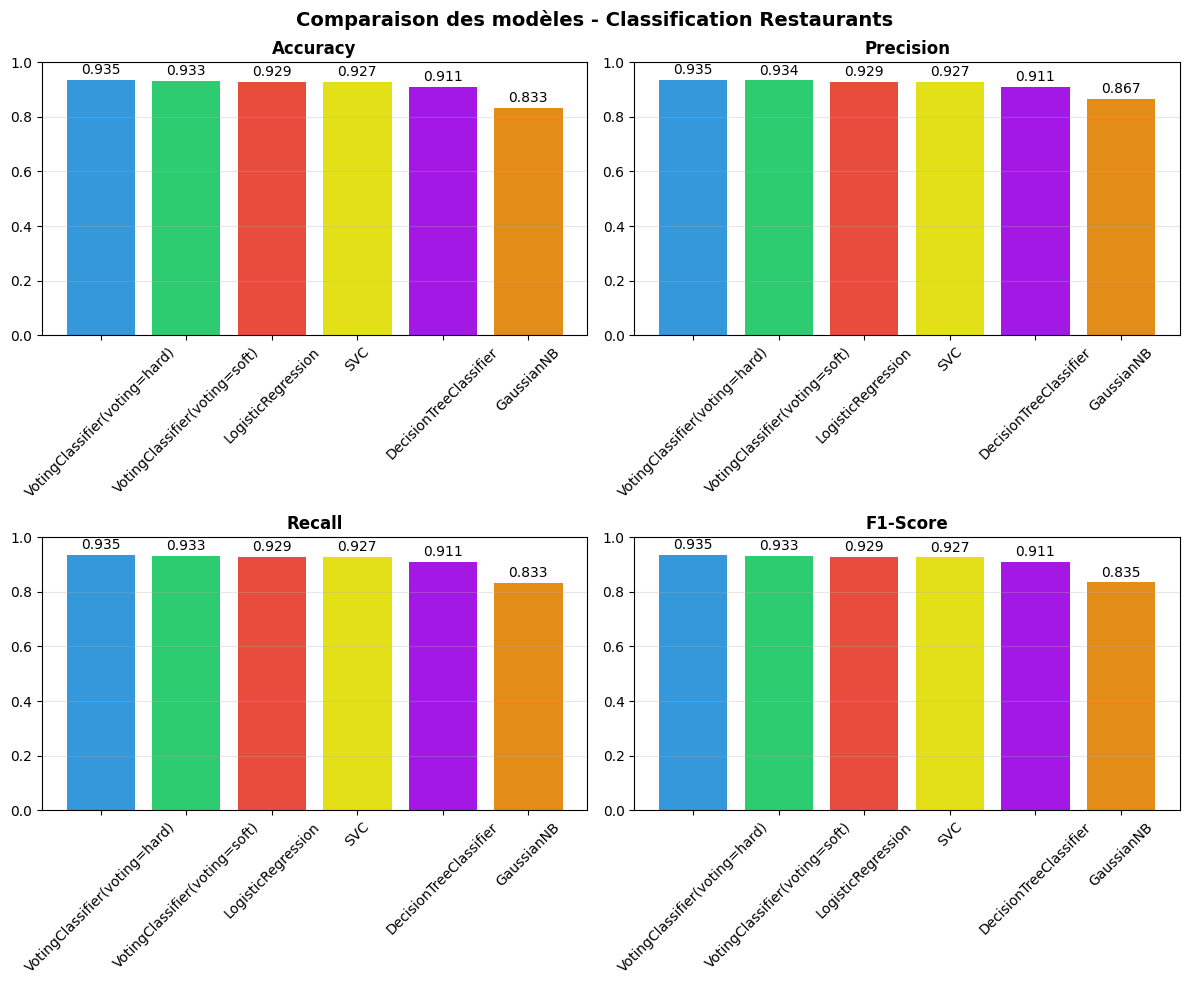

In [14]:
import matplotlib.pyplot as plt

model_names = df_results["Modele"].to_list()
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
colors = ["#3498db", "#2ecc71", "#e74c3c", "#e4e018", "#a318e4", "#e48c18"]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = df_results[metric].to_list()
    bars = ax.bar(model_names, values, color=colors[: len(model_names)])
    ax.set_title(metric, fontweight="bold", fontsize=12)
    ax.set_ylim([0.0, 1.0])
    ax.tick_params(axis="x", rotation=45)
    ax.grid(axis="y", alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + 0.01,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.suptitle(
    "Comparaison des modèles - Classification Restaurants",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()

### 5. Matrice de confusion du meilleur modèle

**Analyse de la matrice** :

- Combien d'emails légitimes sont bloqués par erreur (Faux Positifs) ?
- Combien de spams passent à travers (Faux Négatifs) ?
- Quel type d'erreur est le plus problématique pour l'utilisateur ?

Top modèle :  VotingClassifier(voting=hard)


<Figure size 1200x700 with 0 Axes>

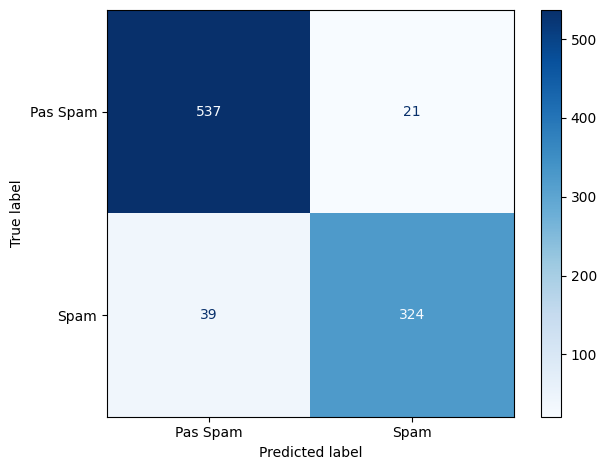

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

top_model = df_results.nlargest(1, "F1-Score")
top_model_name = top_model["Modele"].iloc[0]
print("Top modèle : ", top_model_name)
top_pipeline = models[top_model_name]
y_pred = top_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
display = ConfusionMatrixDisplay(cm, display_labels=["Pas Spam", "Spam"])
display.plot(cmap="Blues")
plt.tight_layout()
